In [1]:
import pandas as pd
import numpy as np
import os
import glob
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from math import cos, pi, radians
from numpy import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
def preprocess_data(data, is_train=True):
    
    temp = data.copy()
    temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]

    if is_train==True:          
    
        temp['Target1'] = temp['TARGET'].shift(-48).fillna(method='ffill')
        temp['Target2'] = temp['TARGET'].shift(-48*2).fillna(method='ffill')
        temp = temp.dropna()
        
        return temp.iloc[:-96]

    elif is_train==False:
        
        temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]
                              
        return temp.iloc[-48:, :]

In [3]:
train = pd.read_csv('./data/train/train.csv')

test = []

for i in range(81):
    file_path = './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp = preprocess_data(temp, is_train=False)
    test.append(temp)

df_test = pd.concat(test)

submission = pd.read_csv('./data/sample_submission.csv')

In [4]:
df_train = preprocess_data(train)

df_train.shape, df_test.shape

((52464, 9), (3888, 7))

In [5]:
cols = ['Hour','DHI','DNI','WS','RH','T']
min = df_train[cols].min()
max  = df_train[cols].max()

In [6]:
for i, col in enumerate(['Hour','DHI','DNI','WS','RH','T']):
    df_train[col] = (df_train[col] - min[i]) / (max[i] - min[i])
    df_test[col] = (df_test[col] - min[i]) / (max[i] - min[i])

<AxesSubplot:>

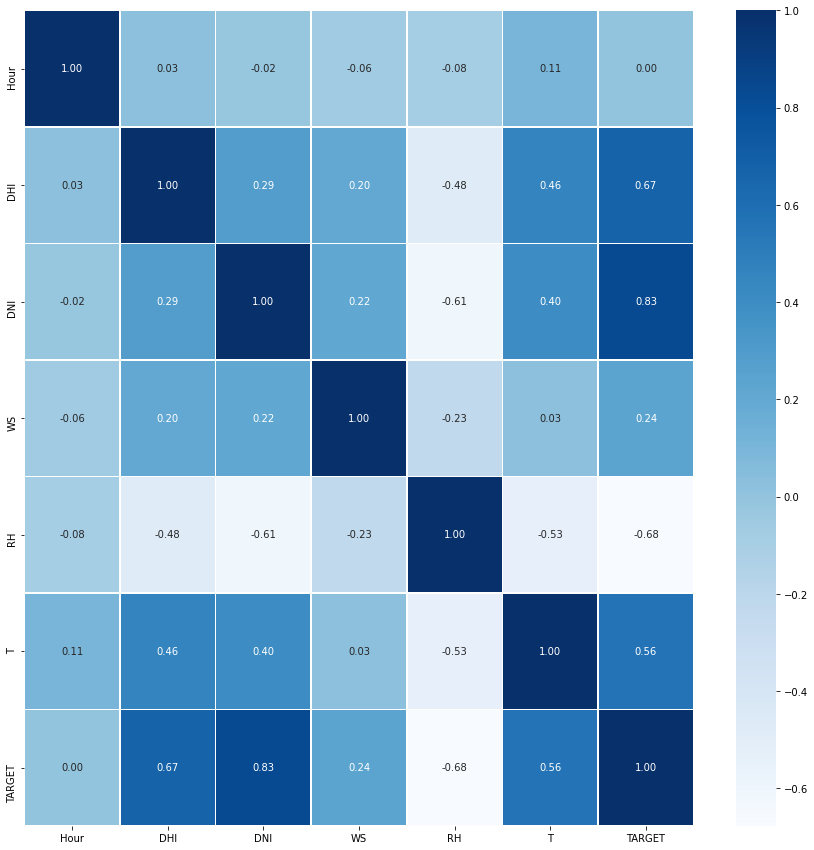

In [7]:
plt.figure(figsize=(15,15))
sns.heatmap(data = df_train[['Hour','DHI','DNI','WS','RH','T','TARGET']].corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

In [9]:
col = ['Hour','TARGET','DHI','DNI','WS','T']

In [13]:
Day  = df_train.loc[:, ['Hour','TARGET','DHI','DNI','WS','T']]#df_train.iloc[:, :-2]
Day7 = df_train.iloc[:, -2]
Day8 = df_train.iloc[:, -1]
Day78 = df_train.iloc[:, -2:]

In [14]:
def quantile_loss(q, y, pred):
    err = (y-pred)
    return mean(maximum(q*err, (q-1)*err), axis=-1)

In [15]:
q_lst = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(Day, Day78, test_size=0.25, random_state=42)

X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(Day, Day7, test_size=0.25, random_state=42)
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(Day, Day8, test_size=0.25, random_state=42)

X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((39348, 6), (13116, 6), (39348, 2), (13116, 2))

In [17]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras import layers
from tensorflow.keras.backend import mean, maximum

tf.random.set_seed(42)

In [18]:
epoch = 100

In [31]:
model = tf.keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(Day.shape)),
    layers.Dense(16, activation='relu'),
    layers.Dense(2)
])

In [28]:
model.compile(loss='mse', optimizer='adam')
hist = model.fit(X_train, Y_train, epochs=epoch, batch_size=48, validation_split=0.25, 
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
model.evaluate(X_valid, Y_valid)

Epoch 1/100
615/615 [==============================] - 1s 1ms/step - loss: 397.7613 - val_loss: 191.0555
Epoch 2/100
615/615 [==============================] - 1s 1ms/step - loss: 182.2849 - val_loss: 173.6266
Epoch 3/100
615/615 [==============================] - 1s 1ms/step - loss: 167.7035 - val_loss: 163.8613
Epoch 4/100
615/615 [==============================] - 1s 1ms/step - loss: 162.9560 - val_loss: 158.1074
Epoch 5/100
615/615 [==============================] - 1s 1ms/step - loss: 156.3673 - val_loss: 157.3323
Epoch 6/100
615/615 [==============================] - 1s 1ms/step - loss: 156.0304 - val_loss: 154.9021
Epoch 7/100
615/615 [==============================] - 1s 979us/step - loss: 155.9564 - val_loss: 152.5645
Epoch 8/100
615/615 [==============================] - 1s 1ms/step - loss: 148.4945 - val_loss: 153.6855
Epoch 9/100
615/615 [==============================] - 1s 1ms/step - loss: 154.1901 - val_loss: 151.4898
Epoch 10/100
615/615 [==============================]

Epoch 69/100
615/615 [==============================] - 1s 1ms/step - loss: 134.5265 - val_loss: 130.4914
Epoch 70/100
615/615 [==============================] - 1s 1ms/step - loss: 136.8479 - val_loss: 131.0530
Epoch 71/100
615/615 [==============================] - 1s 1ms/step - loss: 136.4216 - val_loss: 131.8656
Epoch 72/100
615/615 [==============================] - 1s 1ms/step - loss: 130.7680 - val_loss: 130.3444
Epoch 73/100
615/615 [==============================] - 1s 1ms/step - loss: 132.5813 - val_loss: 131.0059
Epoch 74/100
615/615 [==============================] - 1s 1ms/step - loss: 132.5978 - val_loss: 131.8358
Epoch 75/100
615/615 [==============================] - 1s 1ms/step - loss: 134.2406 - val_loss: 131.2523
Epoch 76/100
615/615 [==============================] - 1s 1ms/step - loss: 131.6176 - val_loss: 131.3505
Epoch 77/100
615/615 [==============================] - 1s 1ms/step - loss: 132.8071 - val_loss: 130.1627
Epoch 78/100
615/615 [========================

130.59530639648438

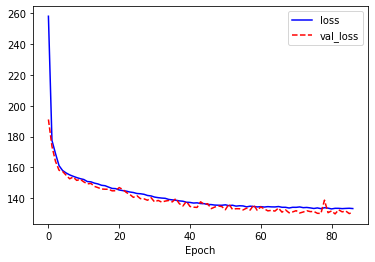

In [29]:
plt.plot(hist.history['loss'], 'b-', label='loss')
plt.plot(hist.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [36]:
col = ['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'T']

In [37]:
results = pd.DataFrame()

for q in q_lst:
    model.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model.fit(Day, Day78, epochs=epoch, batch_size=48, validation_split=0.25, 
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred = pd.DataFrame(model.predict(df_test[col]))
    results = pd.concat([results, pred], axis=1)

results.shape

Epoch 1/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3778 - val_loss: 1.5493
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3837 - val_loss: 1.5504
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3729 - val_loss: 1.5546
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3684 - val_loss: 1.5533
Epoch 5/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3807 - val_loss: 1.5576
Epoch 6/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3749 - val_loss: 1.5680
Epoch 00006: early stopping
Epoch 1/100
820/820 [==============================] - 1s 1ms/step - loss: 2.2576 - val_loss: 2.5474
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 2.2474 - val_loss: 2.5504
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 2.2361 - val_loss: 2.5447
Epoch 4/100
820/820 [==============================] - 1s 1ms/s

820/820 [==============================] - 1s 1ms/step - loss: 2.8376 - val_loss: 3.1515
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 2.8119 - val_loss: 3.1589
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 2.8132 - val_loss: 3.1795
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 2.8077 - val_loss: 3.1479
Epoch 5/100
820/820 [==============================] - 1s 1ms/step - loss: 2.8255 - val_loss: 3.1768
Epoch 6/100
820/820 [==============================] - 1s 1ms/step - loss: 2.8115 - val_loss: 3.1331
Epoch 7/100
820/820 [==============================] - 1s 1ms/step - loss: 2.8400 - val_loss: 3.1432
Epoch 8/100
820/820 [==============================] - 1s 1ms/step - loss: 2.8546 - val_loss: 3.1471
Epoch 9/100
820/820 [==============================] - 1s 1ms/step - loss: 2.8200 - val_loss: 3.1201
Epoch 10/100
820/820 [==============================] - 1s 1ms/step - loss: 2.8562 - val_loss: 3.1296
E

Epoch 1/100
820/820 [==============================] - 1s 1ms/step - loss: 1.9552 - val_loss: 2.2082
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 1.9380 - val_loss: 2.2062
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 1.9426 - val_loss: 2.2080
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 1.9408 - val_loss: 2.2424
Epoch 5/100
820/820 [==============================] - 1s 1ms/step - loss: 1.9472 - val_loss: 2.1947
Epoch 6/100
820/820 [==============================] - 1s 1ms/step - loss: 1.9398 - val_loss: 2.1905
Epoch 7/100
820/820 [==============================] - 1s 1ms/step - loss: 1.9600 - val_loss: 2.1823
Epoch 8/100
820/820 [==============================] - 1s 1ms/step - loss: 1.9731 - val_loss: 2.2159
Epoch 9/100
820/820 [==============================] - 1s 1ms/step - loss: 1.9380 - val_loss: 2.1795
Epoch 10/100
820/820 [==============================] - 1s 1ms/step - loss: 1.9656 - val_lo

(3888, 18)

In [ ]:
results[0], results[1]

In [38]:
from lightgbm import LGBMRegressor

In [39]:
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', alpha=q,
                         n_estimators=10000, bagging_fraction=0.7, learning_rate=0.027, subsample=0.7)                   
                         
                         
    model.fit(X_train, Y_train, eval_metric = ['quantile'], 
          eval_set=[(X_valid, Y_valid)], early_stopping_rounds=300, verbose=500)

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in q_lst:
        print(q)
        pred , model = LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)

    LGBM_actual_pred.columns=q_lst
    
    return LGBM_models, LGBM_actual_pred

models_1, results_1 = train_data(X_train_1, Y_train_1, X_valid_1, Y_valid_1, df_test[col])
models_2, results_2 = train_data(X_train_2, Y_train_2, X_valid_2, Y_valid_2, df_test[col])

0.1
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 1.36617
[1000]	valid_0's quantile: 1.36016
Early stopping, best iteration is:
[749]	valid_0's quantile: 1.3584
0.2
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.17455
[1000]	valid_0's quantile: 2.16986
Early stopping, best iteration is:
[1110]	valid_0's quantile: 2.16823
0.3
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.58779
[1000]	valid_0's quantile: 2.57167
[1500]	valid_0's quantile: 2.56953
[2000]	valid_0's quantile: 2.56619
[2500]	valid_0's quantile: 2.56325
Early stopping, best iteration is:
[2453]	valid_0's quantile: 2.56258
0.4
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.70932
[1000]	valid_0's quantile: 2.6949
[1500]	valid_0's quantile: 2.68525
[2000]	valid_0's quantile: 2.68347
Early stopping, best iteration is:
[1899]	valid_0's quantile: 2.68228
0.5
Trai

In [40]:
res_L0 = pd.DataFrame(results_1.sort_index())
res_L0.columns = ['L00.1','L00.2','L00.3','L00.4','L00.5','L00.6','L00.7','L00.8','L00.9']
res_L1 = pd.DataFrame(results_1.sort_index())
res_L1.columns = ['L10.1','L10.2','L10.3','L10.4','L10.5','L10.6','L10.7','L10.8','L10.9']

res_D0 = pd.DataFrame(results[0].sort_index())
res_D0.columns = ['D00.1','D00.2','D00.3','D00.4','D00.5','D00.6','D00.7','D00.8','D00.9']
res_D1 = pd.DataFrame(results[1].sort_index())
res_D1.columns = ['D10.1','D10.2','D10.3','D10.4','D10.5','D10.6','D10.7','D10.8','D10.9']

In [41]:
res_0 = pd.concat([res_L0, res_D0], axis=1)
res_1 = pd.concat([res_L1, res_D1], axis=1)

In [42]:
res_0.loc[res_0[res_0['L00.1'] == 0].index, ['D00.1','D00.2','D00.3','D00.4','D00.5','D00.6','D00.7','D00.8','D00.9']] = 0
res_1.loc[res_1[res_1['L10.1'] == 0].index, ['D10.1','D10.2','D10.3','D10.4','D10.5','D10.6','D10.7','D10.8','D10.9']] = 0

In [43]:
for i in range(1, 10):
    res_0["L00."+str(i)] = (res_0["L00."+str(i)] + res_0["D00."+str(i)])/2
    res_1["L10."+str(i)] = (res_1["L10."+str(i)] + res_1["D10."+str(i)])/2

In [44]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = res_0[['L00.1','L00.2','L00.3','L00.4','L00.5','L00.6','L00.7','L00.8','L00.9']].values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = res_1[['L10.1','L10.2','L10.3','L10.4','L10.5','L10.6','L10.7','L10.8','L10.9']].values
submission[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.csv_Day7_0h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.csv_Day7_1h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.csv_Day7_1h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.csv_Day7_2h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.csv_Day7_2h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.csv_Day7_3h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.csv_Day7_3h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.csv_Day7_4h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.csv_Day7_4h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [45]:
submission.to_csv('./submission/submission_20210119-1.csv', index=False)

In [ ]:
results_1.sort_index()[:48]

In [ ]:
results[0].sort_index()[:48]

In [ ]:
(0.94+0.480766)/2

In [ ]:
(9.45 + 9.181172)/2

In [ ]:
df_test[:48]